# **Introduction to Deep Q-Networks and the Lunar Lander Problem**

# Table of Contents




- [Introduction to Deep Q-Networks and the Lunar Lander Problem](#introduction-to-deep-q-networks-and-the-lunar-lander-problem)
- [Overview and Objectives](#overview-and-objectives)
- [Setup](#setup)
- [DQN](#dqn)
  - [Implementing DQN Components](#implementing-dqn-components)
    - [Replay Memory Class](#replay-memory-class)
    - [DQN Network Class](#dqn-network-class)
    - [DQN Agent Class](#dqn-agent-class)
  - [Model TrainTest Class](#model-traintest-class)
    - [State Preprocessing](#state-preprocessing)
    - [Training](#training)
    - [Testing](#testing)
    - [Visualization](#visualization)


## **Introduction to Deep Q-Networks and the Lunar Lander Problem**

The Lunar Lander problem is a classic test in the field of reinforcement learning where the objective is to land a spaceship on a designated landing pad. The spaceship is equipped with a main engine and two side engines, and the agent must learn to control these engines to land safely.

## **Overview and Objectives**

This project utilizes Deep Q-Network (DQN), a popular reinforcement learning algorithm, to address the Lunar Lander problem. DQN combines Q-Learning with deep neural networks to create a robust approach capable of learning successful policies directly from high-dimensional sensory inputs.


### Objectives



- **Implement the DQN Algorithm**: Utilize PyTorch to implement the DQN algorithm.
- **Train and Evaluate the Model**: Train the model to land the spaceship on the landing pad and evaluate its performance across different training epochs.
- **Assess Algorithm Effectiveness**: Analyze how effectively the DQN algorithm learns to solve the Lunar Lander problem compared to other potential methods.


#**Setup**

### **Running the Notebook**

This notebook is designed to run in Google Colab. It requires no additional setup from the user's local environment except access to the internet and a Google account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installation of Required Libraries

Before we start implementing the algorithms, we need to ensure that all necessary libraries are installed. Run the following cells to install the required packages.

In [ ]:
!pip install gymnasium
!pip install torch
!pip install renderlab

!pip install wheel setuptools pip --upgrade
!pip install swig
!pip install gymnasium[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376135 sha256=31ff338c08965fd31d0d8ee80273dc5bb6c09ca953139801a8d63443bda9beeb
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


### Importing Libraries

Now, let's import the necessary libraries that we will use throughout this project.

In [ ]:
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
import renderlab
import pygame
import matplotlib.image as mpimg


### Setting Up GPU and Reproducibility

This section initializes the environment and sets up the GPU (if available) for computation. It also ensures reproducibility by setting random seeds.

In [ ]:
print(f"torch.cuda: {torch.cuda.is_available()}" )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.cuda: False
Using device: cpu


In [ ]:
# Clear memory and set random seeds for reproducibility
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Immediate CUDA error reporting
seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# **DQN**


## **Implementing DQN components**


In this section, we implement the `ReplayMemory`, `DQN_Network` and `DQN_Agent` classes.

### Replay Memory Class

The `ReplayMemory` class manages a buffer for storing experiences observed during interactions with the environment. This buffer is crucial for training deep reinforcement learning algorithms such as Deep Q-Networks (DQN). Here's a brief overview of its methods:

*    `__init__(self, capacity):` Initializes the replay memory with a specified capacity.

*    `store(self, state, action, next_state, reward, done):` Stores an experience **(state, action, next_state, reward, done)** in the replay memory.

*    `sample(self, batch_size):` Samples a batch of experiences from the replay memory.

*   ` __len__(self)`: Returns the current size of the replay memory.

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        # Initialize replay memory with a specified capacity
        self.capacity = capacity
        self.states = deque(maxlen=capacity)
        self.actions = deque(maxlen=capacity)
        self.next_states = deque(maxlen=capacity)
        self.rewards = deque(maxlen=capacity)
        self.dones = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        # Store an experience (state, action, next_state, reward, done) in the replay memory
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)

    def sample(self, batch_size):
        # Sample a batch of experiences from the replay memory
        indices = np.random.choice(len(self), size=batch_size, replace=False)
        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices])
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device) for i in indices])
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32, device=device)
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)
        return states, actions, next_states, rewards, dones

    def __len__(self):
        # Return the current size of the replay memory
        return len(self.dones)


### DQN Network Class

The `DQN_Network` class implements the architecture of a Deep Q-Network (DQN) for reinforcement learning. Here's a concise breakdown:

- **Description**: The class represents a neural network model tailored for reinforcement learning tasks, featuring fully connected layers with Rectified Linear Unit (ReLU) activations.

- **Initialization**:
    - `__init__`: Initializes the DQN network with parameters:
        - `num_actions`: Number of possible actions in the environment.
        - `input_dim`: Dimensionality of the input state space.
    - Defines a sequential stack of fully connected layers (`nn.Linear`) followed by ReLU activations.

- **Weight Initialization**:
    - `_initialize_weights`: Initializes weights using *He initialization* for ReLU activations, setting bias values to 0.01.

- **Forward Pass**:
    - `forward`: Computes Q-values for each action given an input state tensor (`x`) by passing it through the defined fully connected layers (`self.FC`).

This class serves as the backbone for Q-value estimation in reinforcement learning, providing an efficient architecture for learning and decision-making.

In [ ]:
class DQN_Network(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning with a stronger architecture.
    This network consists of Fully Connected (FC) layers with ReLU activation functions.
    """

    def __init__(self, num_actions, input_dim):
        """
        Initialize the DQN network with a more complex architecture.

        Parameters:
            num_actions (int): The number of possible actions in the environment.
            input_dim (int): The dimensionality of the input state space.
        """
        super(DQN_Network, self).__init__()

        # Define the neural network layers
        self.FC = nn.Sequential(
            nn.Linear(input_dim, 128),  # Input layer to first hidden layer with 512 nodes
            nn.ReLU(inplace=True),                 # ReLU activation for non-linearity
            nn.Linear(128, 64),       # Second hidden layer with 256 nodes
            nn.ReLU(inplace=True),                 # ReLU activation for non-linearity
            nn.Linear(64, 32),        # Third hidden layer with 64 nodes
            nn.ReLU(inplace=True),                 # ReLU activation for non-linearity
            nn.Linear(32, num_actions) # Output layer with 'num_actions' nodes
        )

        # Initialize weights using He initialization (also known as Kaiming initialization)
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialize weights using He initialization suitable for ReLU activations
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def forward(self, x):
        """
        Forward pass of the network to compute the Q-values for each action.

        Parameters:
            x (torch.Tensor): Input tensor representing the state.

        Returns:
            Q (torch.Tensor): Tensor containing Q-values for each action.
        """
        return self.FC(x)


### DQN Agent Class



The `DQN_Agent` class encapsulates key components of the Deep Q-Network (DQN) algorithm, including learning methodology, target network update, and action selection strategies. Here's a concise summary:

- **Description**: This class orchestrates the learning process of the DQN algorithm, managing the interaction between the agent and its environment.

- **Initialization**:
    - `__init__`: Initializes the agent with parameters such as epsilon-greedy exploration settings, gradient clipping, learning rate, discount factor, and memory capacity.
    - Sets up key attributes including loss history, network models (main and target), optimizer, and replay memory.

- **Action Selection**:
    - `select_action`: Implements action selection based on an epsilon-greedy strategy or exploiting Q-values.
    - During exploration, it randomly selects actions with probability epsilon_max.
    - During exploitation, it selects actions with the highest Q-values.

- **Learning**:
    - `learn`: Trains the main network using experiences sampled from the replay memory.
    - Computes Q-values for the current states and selects corresponding Q-values for the actions taken.
    - Computes the target Q-values using the target network for next states and calculates the loss.
    - Updates the main network parameters using backpropagation and gradient clipping.

- **Target Network Update**:
    - `hard_update`: Updates the parameters of the target network by directly copying from the main network.

- **Epsilon Decay**:
    - `update_epsilon`: Updates the value of epsilon for epsilon-greedy exploration over time according to a decay factor.

- **Model Saving**:
    - `save`: Saves the parameters of the main network to a file with a .pth extension.

In [ ]:
class DQN_Agent:
    """
    DQN Agent Class. This class defines some key elements of the DQN algorithm,
    such as the learning method, hard update, and action selection based on the
    Q-value of actions or the epsilon-greedy policy.
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay,
                 clip_grad_norm, learning_rate, discount, memory_capacity, beta):

        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

        # RL hyperparameters
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount = discount

        self.state_size = env.observation_space.shape[0]
        self.action_space = env.action_space
        self.action_space.seed(seed)  # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)

        # Initiate the network models
        self.main_network = DQN_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device)
        self.target_network = DQN_Network(input_dim=(self.state_size), num_actions=self.action_space.n).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm  # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)

    def select_action(self, state):
        """
        Selects an action using epsilon-greedy strategy OR based on the Q-values.

        Parameters:
            state (torch.Tensor): Input tensor representing the state.

        Returns:
            action (int): The selected action.
        """

        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: the action is selected based on the Q-values.
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()

            return action

    def learn(self, batch_size, done):
        """
        Train the main network using a batch of experiences sampled from the replay memory.

        Parameters:
            batch_size (int): The number of experiences to sample from the replay memory.
            done (bool): Indicates whether the episode is done or not. If done,
            calculate the loss of the episode and append it in a list for plot.
        """

        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)

        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)

        predicted_q = self.main_network(states)  # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(dim=1, index=actions)  # selecting the Q-values of the actions that were actually taken

        # Compute the maximum Q-value for the next states using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]  # not argmax (cause we want the maxmimum q-value, not the action that maximize it)

        next_target_q_value[dones] = 0  # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value)  # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js)  # Compute the loss

        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = self.running_loss / self.learned_counts  # The average loss for the episode
            self.loss_history.append(episode_loss)  # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Perform backward pass and update the gradients

        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)

        self.optimizer.step()  # Update the parameters of the main network using the optimizer


    def soft_update(self, beta):
        """
        Navie update: Update the target network parameters by directly copying
        the parameters from the main network.
        """

        for target_param, main_param in zip(self.target_network.parameters(), self.main_network.parameters()):
            target_param.data.copy_((1.0 - beta) * main_param.data + beta * target_param.data)

    def update_epsilon(self):
        """
        Update the value of epsilon for epsilon-greedy exploration.

        This method decreases epsilon over time according to a decay factor, ensuring
        that the agent becomes less exploratory and more exploitative as training progresses.
        """

        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)


    def mean_q_value(self):
        """
        Compute the mean of the Q-values for all states in the replay memory.

        Returns:
            float: The mean Q-value.
        """
        if len(self.replay_memory) == 0:
            return 0.0

        with torch.no_grad():
            all_states = torch.stack([torch.as_tensor(
                state, dtype=torch.float32, device=device)for state in self.replay_memory.states])
            Q_values = self.main_network(all_states)
            mean_q_value = Q_values.mean().item()

        return mean_q_value


    def save(self, path):
        """
        Save the parameters of the main network to a file with .pth extention.

        """
        torch.save(self.main_network.state_dict(), path)


### Model TrainTest Class


The `Model_TrainTest` class manages the training and testing of the reinforcement learning model. Here's a concise breakdown of its functionality:

- **Initialization**:
    - Initializes the class with hyperparameters for training and testing.
    - Sets up attributes such as training mode, paths for saving and loading models, reporting intervals, etc.
    - Creates the environment (`env`) using Gym and initializes the DQN agent.

- **State Preprocessing**:
    - `state_preprocess`: Converts the raw state into a tensor and encodes it into a one-hot vector.

- **Training**:
    - `train`: Implements the reinforcement learning training loop.
    - Iterates over episodes, performs actions, observes rewards, and updates the agent's Q-network.
    - Handles epsilon-greedy exploration, reward shaping, replay memory storage, and target network updates.
    - Saves the model at specified intervals and reports training progress.

- **Testing**:
    - `test`: Evaluates the policy learned by the agent.
    - Loads the trained model weights and runs the agent in the environment without exploration.
    - Logs episode-wise rewards and steps taken during testing.

- **Visualization**:
    - `plot_training`: Plots the training rewards and loss over episodes.
    - Calculates the Simple Moving Average (SMA) of rewards for smooth visualization.
    - Saves the plots as files if it's the last episode.



In [ ]:
class Model_TrainTest:
    def __init__(self, hyperparams):

        # Define RL Hyperparameters
        self.train_mode = hyperparams["train_mode"]
        self.RL_load_path = hyperparams["RL_load_path"]
        self.save_path = hyperparams["save_path"]
        self.save_interval = hyperparams["save_interval"]
        self.report = hyperparams["report"]
        self.early_stop_threshold = hyperparams["early_stop_threshold"]
        self.early_stop_window = hyperparams["early_stop_window"]
        self.render_output_path = hyperparams["render_output_path"]

        self.clip_grad_norm = hyperparams["clip_grad_norm"]
        self.learning_rate = hyperparams["learning_rate"]
        self.discount_factor = hyperparams["discount_factor"]
        self.batch_size = hyperparams["batch_size"]
        self.update_frequency = hyperparams["update_frequency"]
        self.max_episodes = hyperparams["max_episodes"]
        self.max_steps = hyperparams["max_steps"]
        self.render = hyperparams["render"]

        self.epsilon_max = hyperparams["epsilon_max"]
        self.epsilon_min = hyperparams["epsilon_min"]
        self.epsilon_decay = hyperparams["epsilon_decay"]
        self.beta = hyperparams["beta"]

        self.memory_capacity = hyperparams["memory_capacity"]

        self.num_states = hyperparams["num_states"]
        self.map_size = hyperparams["map_size"]
        self.render_fps = hyperparams["render_fps"]

        # Define Env
        self.env = gym.make('LunarLander-v2',
                            render_mode="rgb_array" if self.render else None)
        self.env.metadata['render_fps'] = self.render_fps  # For max frame rate make it 0
        # Define the agent class
        self.agent = DQN_Agent(env=self.env,
                               epsilon_max=self.epsilon_max,
                               epsilon_min=self.epsilon_min,
                               epsilon_decay=self.epsilon_decay,
                               clip_grad_norm=self.clip_grad_norm,
                               learning_rate=self.learning_rate,
                               discount=self.discount_factor,
                               memory_capacity=self.memory_capacity,
                               beta=hyperparams["beta"])

    def state_preprocess(self, state: int, num_states: int):
        """
        Convert an state to a tensor and basically it encodes the state into
        an onehot vector. For example, the return can be something like tensor([0,0,1,0,0])
        which could mean agent is at state 2 from total of 5 states.

        """
        # onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
        # onehot_vector[state] = 1
        state = torch.tensor(state, dtype=torch.float32, device=device)
        return state

    def train(self):
        """
        Reinforcement learning training loop.
        """

        total_steps = 0
        self.reward_history = []
        self.mean_q_hitsory = []
        self.epsilon_history = []

        consecutive_rewards = 0

        # Training loop over episodes
        for episode in range(1, self.max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)
                self.agent.replay_memory.store(state, action, next_state, reward, done)

                if len(self.agent.replay_memory) > self.batch_size:
                    self.agent.learn(self.batch_size, (done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.soft_update(self.beta)  # Use soft update instead of hard update
                state = next_state
                episode_reward += reward
                step_size += 1

            # Appends for tracking history
            self.reward_history.append(episode_reward)  # episode reward
            mean = self.agent.mean_q_value()
            self.mean_q_hitsory.append(mean)
            self.epsilon_history.append(self.agent.epsilon_max)
            total_steps += step_size

            if episode_reward >= self.early_stop_threshold:
                consecutive_rewards += 1
            else:
                consecutive_rewards = 0

             # Check for early stopping condition
            if consecutive_rewards >= self.early_stop_window:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Epsilon: {self.agent.epsilon_max:.2f}",
                          f"Mean Q-value: {mean:.2f}")
                print(result)
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                print(f"Early stopping at episode {episode} as reward exceeded threshold for {self.early_stop_window} consecutive episodes.")
                break
            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()

            # -- based on interval
            if episode % self.save_interval == 0 or episode == self.max_episodes or episode == 10:
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                # if episode != self.max_episodes:
                    # self.plot_training(episode)
                print('\n~~~~~~Interval Save: Model saved.\n')

            if episode % self.report == 0:
                result = (f"Episode: {episode}, "
                          f"Total Steps: {total_steps}, "
                          f"Ep Step: {step_size}, "
                          f"Raw Reward: {episode_reward:.2f}, "
                          f"Epsilon: {self.agent.epsilon_max:.5f}")
                print(result)
        self.plot_training(episode)

    def test(self, max_episodes):
        """
        Reinforcement learning policy evaluation.
        """
        env = renderlab.RenderFrame(self.env, self.render_output_path)
        # Load the weights of the test_network
        print(f"loading from {self.RL_load_path}")
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path, map_location=torch.device('cpu')))
        self.agent.main_network.eval()

        # Testing loop over episodes
        for episode in range(1, max_episodes + 1):
            state, _ = env.reset(seed=seed)
            # state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                state = self.state_preprocess(state, num_states=self.num_states)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = env.step(action)
                # next_state, reward, done, truncation, _ = self.env.step(action)

                state = next_state
                episode_reward += reward
                step_size += 1

            # Print log
            result = (f"total Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f}, ")
            print(result)


        env.play()
        pygame.quit()  # close the rendering window

    def plot_training(self, episode):
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50) / 50, mode='valid')

        # Plot Rewards
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Loss_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()

        plt.figure()
        plt.title("Mean Of Q Value Hitsory")
        plt.plot(np.arange(1, episode + 1), self.mean_q_hitsory, color='g')
        plt.xlabel("Episode")
        plt.ylabel("Mean Q")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./mean_q_hitsory.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()


        # Plot Epsilon Decay (ε-greedy)
        plt.figure()
        plt.title("Epsilon Decay (ε-greedy)")
        plt.plot(np.arange(1, episode + 1), self.epsilon_history, color='g')
        plt.xlabel("Episode")
        plt.ylabel("Epsilon")
        plt.tight_layout()
        plt.grid(True)
        plt.savefig('./Epsilon_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.close()


## **Train and Test the DQN agent**

In [ ]:
cd drive/MyDrive/DRL/

/content/drive/MyDrive/DRL


In [ ]:
ls

cartpole/  lunar_lander/


In [ ]:
mkdir lunar_lander

mkdir: cannot create directory ‘lunar_lander’: File exists


In [ ]:
cd lunar_lander/

/content/drive/MyDrive/DRL/lunar_lander


In [ ]:
cd DQN_2

/content/drive/MyDrive/DRL/lunar_lander/DQN_2


In [ ]:
def handler(train_mode=True, RL_hyperparameters = {}):
    # Initialize and run the model
    DRL = Model_TrainTest(RL_hyperparameters)
    if train_mode:
        DRL.train()
    else:
        DRL.test(max_episodes=RL_hyperparameters['max_episodes'])

In [ ]:
def set_hyperparameters(train_mode):
    render = not train_mode
    RL_hyperparams = {
        "train_mode": train_mode,
        "RL_load_path": f'./final_weights_{"2000"}.pth',
        "save_path": './final_weights',
        "render_output_path": "./output",
        "early_stop_threshold": 240,
        "early_stop_window": 30,
        "save_interval": 500,
        "report": 30,
        "clip_grad_norm": 3,
        "learning_rate": 2e-4,
        "discount_factor": 0.9965,
        "batch_size": 64,
        "update_frequency": 10,
        "max_episodes": 2000 if train_mode else 1,
        "max_steps": 1000,
        "render": render,
        "epsilon_max": 0.999 if train_mode else -1,
        "epsilon_min": 0.00001,
        "epsilon_decay": 0.995,
        "memory_capacity": 6_000 if train_mode else 0,
        "map_size": 8,
        "num_states": 8 ** 2,
        "render_fps": 30,
        "beta": 0.995,
    }
    return RL_hyperparams

In [ ]:
############do not run #################

In [ ]:
if __name__ == '__main__':
    RL_hyperparameters = set_hyperparameters(train_mode=True)
    handler(train_mode=True, RL_hyperparameters=RL_hyperparameters)  # For training


~~~~~~Interval Save: Model saved.

Episode: 30, Total Steps: 2930, Ep Step: 95, Raw Reward: -152.26, Epsilon: 0.92673
Episode: 60, Total Steps: 5902, Ep Step: 94, Raw Reward: -168.15, Epsilon: 0.85969
Episode: 90, Total Steps: 9092, Ep Step: 130, Raw Reward: -173.13, Epsilon: 0.79749
Episode: 120, Total Steps: 12429, Ep Step: 126, Raw Reward: -116.50, Epsilon: 0.73980
Episode: 150, Total Steps: 15954, Ep Step: 103, Raw Reward: -177.40, Epsilon: 0.68628
Episode: 180, Total Steps: 20597, Ep Step: 139, Raw Reward: -6.58, Epsilon: 0.63663
Episode: 210, Total Steps: 24668, Ep Step: 171, Raw Reward: -56.10, Epsilon: 0.59058
Episode: 240, Total Steps: 29841, Ep Step: 144, Raw Reward: -76.08, Epsilon: 0.54785
Episode: 270, Total Steps: 37273, Ep Step: 128, Raw Reward: -52.88, Epsilon: 0.50822
Episode: 300, Total Steps: 48793, Ep Step: 1000, Raw Reward: -66.10, Epsilon: 0.47145
Episode: 360, Total Steps: 77200, Ep Step: 1000, Raw Reward: 93.01, Epsilon: 0.40571
Episode: 390, Total Steps: 90368

In [ ]:
ls

Epsilon_plot.png        final_weights_10.pth    Loss_plot.png       reward_plot.png  weights1000/
final_weights_1000.pth  final_weights_1637.pth  mean_q_hitsory.png  weights10/       weights1637/


In [ ]:
def load_and_display_figures(main_title, loss_path, reward_path, epsilon_path, mean_q_path):
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Load and display Loss plot
    loss_img = mpimg.imread(loss_path)
    axs[0].imshow(loss_img)
    axs[0].axis('off')
    axs[0].set_title('Loss Plot')

    # Load and display Reward plot
    reward_img = mpimg.imread(reward_path)
    axs[1].imshow(reward_img)
    axs[1].axis('off')
    axs[1].set_title('Reward Plot')

    # Load and display Epsilon plot
    epsilon_img = mpimg.imread(epsilon_path)
    axs[2].imshow(epsilon_img)
    axs[2].axis('off')
    axs[2].set_title('Epsilon Plot')

    # Load and display Epsilon plot
    mean_q_img = mpimg.imread(mean_q_path)
    axs[3].imshow(mean_q_img)
    axs[3].axis('off')
    axs[3].set_title('Mean Q Plot')

    # Add main title
    fig.suptitle(main_title, fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()

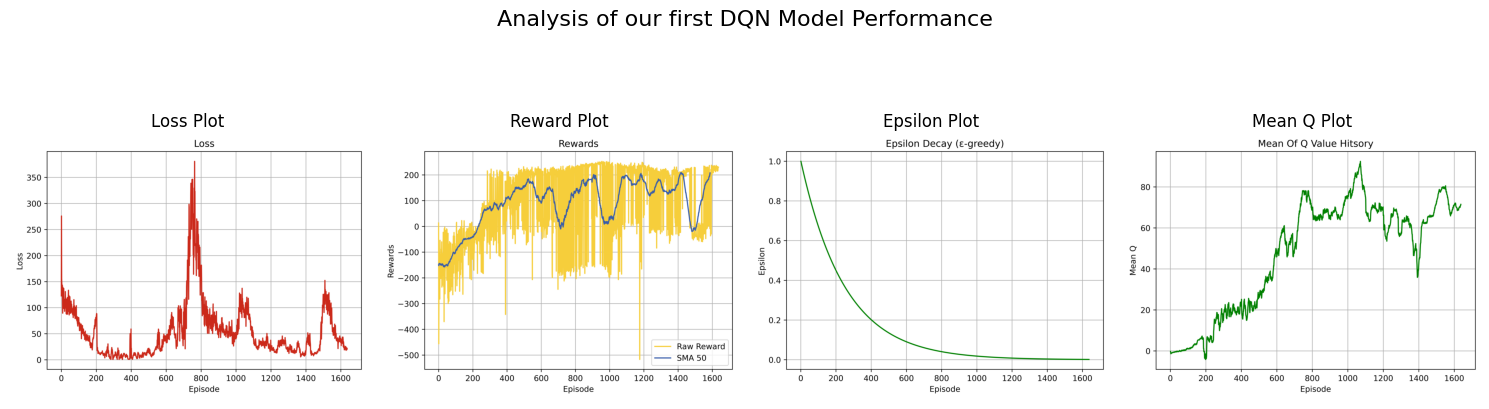

In [ ]:
# Example usage
main_title = "Analysis of our first DQN Model Performance"
# epsilon_path = "Epsilon_plot.png"
loss_path = "Loss_plot.png"
reward_path = "reward_plot.png"
mean_q_path = "mean_q_hitsory.png"
epsilon_path = "Epsilon_plot.png"

load_and_display_figures(main_title, loss_path, reward_path, epsilon_path, mean_q_path)


In [ ]:
ls

Epsilon_plot.png        final_weights_10.pth    Loss_plot.png       reward_plot.png  weights1000/
final_weights_1000.pth  final_weights_1637.pth  mean_q_hitsory.png  weights10/       weights1637/


In [ ]:
print("Testing the DQN agent with it's weights of epoch 10: ")
RL_hyperparameters = set_hyperparameters(train_mode=False)
RL_hyperparameters["render_output_path"] = "./weights10"
RL_hyperparameters["RL_load_path"] = "./final_weights_10.pth"
handler(train_mode=False, RL_hyperparameters=RL_hyperparameters)

Testing the DQN agent with it's weights of epoch 10: 
loading from ./final_weights_10.pth
total Steps: 118, Reward: -767.58, 
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  90%|█████████ | 108/120 [00:00<00:00, 179.61it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./weights10/1717158150.933035.mp4, 720000 bytes wanted but 0 bytes read,at frame 119/120, at time 3.97/3.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
print("Testing the DQN agent with it's weights of epoch 1000: ")
RL_hyperparameters = set_hyperparameters(train_mode=False)
RL_hyperparameters["render_output_path"] = "./weights1000"
RL_hyperparameters["RL_load_path"] = "./final_weights_1000.pth"
handler(train_mode=False, RL_hyperparameters=RL_hyperparameters)

Testing the DQN agent with it's weights of epoch 1000: 
loading from ./final_weights_1000.pth
total Steps: 191, Reward: 243.91, 
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
print("Testing the DQN agent with it's weights of epoch 1637: ")
RL_hyperparameters = set_hyperparameters(train_mode=False)
RL_hyperparameters["render_output_path"] = "./weights1637"
RL_hyperparameters["RL_load_path"] = "./final_weights_1637.pth"
handler(train_mode=False, RL_hyperparameters=RL_hyperparameters)

Testing the DQN agent with it's weights of epoch 1637: 
loading from ./final_weights_1637.pth
total Steps: 183, Reward: 229.62, 
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
